In [1]:
#>> Classification of cats and dogs

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from PIL import Image 

import torch 
import torchvision 
from torchvision import transforms 

from torch.utils.data import Dataset 
from torch.utils.data import DataLoader 
import torch.nn.functional as F

import glob 
import os 

In [2]:
def imshow(img, title = None):
    npimg = img.numpy()[0]
    plt.imshow(npimg, cmap='gray')
    if title != None:
        plt.title(title)
    plt.show()

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes   = os.listdir(path)
        self.path      = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*.jpg") for x in self.path]
        self.transform = transform
        
        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        output = [0, 0]
        output[classCategory] = 1
        return im, classCategory

In [4]:
mean = [0.456]
std  = [0.225]
image_size = (100, 100)
image_row_size = image_size[0] * image_size[1]
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.Grayscale(),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std),
])

In [9]:
path    = '/home/shashwat/data/cats-and-dogs/training_set'
dataset = CatDogDataset(path, transform)
path    = '/home/shashwat/data/cats-and-dogs/test_set'
testset = CatDogDataset(path, transform)
print(len(dataset), len(testset))

8000 2000


In [10]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [11]:
# Input (N images) N x 1 x 100 x 100  (1 channel (grayscale))
# Output N x 2
model = torch.nn.Sequential(
    # N x 1 x 100 x 100
    torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
    # N x 32 x 98 x 98
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    # N x 32 x 49 x 49
    torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
    # N x 64 x 47 x 47
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    # N x 64 x 23 x 23
    torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3)),
    # N x 128 x 21 x 21
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    # N x 128 x 10 x 10
    torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3)),
    # N x 128 x 8 x 8
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    # N x 128 x 4 x 4
    Flatten(),
    # N x 2048
    torch.nn.Linear(2048, 512),
    # N x 512
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2),
    # N x 2
    torch.nn.Sigmoid(),
    # N x 2
    torch.nn.Softmax(dim = 1)
)

In [16]:
def train(load_model = False):
    shuffle     = True
    batch_size  = 64
    num_workers = 0
    dataloader  = DataLoader(dataset=dataset, 
        shuffle=shuffle, 
        batch_size=batch_size, 
        num_workers=num_workers)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.2, amsgrad=True)

    # Load previous model
    if load_model:
        model.load_state_dict(torch.load('../models/dogcat.pth'))
        model.eval()
        print('Model loaded')

    ###### Train ######
    epochs = 30
    tot_itr = 20
    for epoch in range(epochs):
        print('Epoch == ', epoch)

        tot_correct = 0
        for (i, (X, Y)) in enumerate(dataloader):
            yhat = model(X)
            # yhat: N x 2
            # Y: N
            loss = criterion(yhat, Y)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            
            # for i in model[15].parameters():
            #     print(i)

            # Calculate accuracy
            y_pred = torch.argmax(yhat, dim = 1)
            correct = torch.sum(y_pred == Y).item()
            tot_correct += correct

            if i % tot_itr == tot_itr - 1:
                print(str(i), 'Loss', str(round(loss.item(), 4)), 'Batch Accuracy',
                    str(correct / Y.size()[0] * 100))

        print('Accuracy on the training set', tot_correct / dataloader.dataset.__len__() * 100)

    # Save the trained model
    torch.save(model.state_dict(), '../models/dogcat.pth')
    print('Model saved')

## end of train() 

In [19]:
##### Test ######
def test():
    model.load_state_dict(torch.load('../models/dogcat.pth'))
    model.eval()
    print('Model loaded')

    shuffle     = True    # To display random samples
    batch_size  = 256
    num_workers = 0
    testloader  = DataLoader(dataset=dataset, 
        shuffle=shuffle, 
        batch_size=batch_size, 
        num_workers=num_workers)

    tot_correct = 0
#     tot_itr = 20
    for (i, (X, Y)) in enumerate(testloader):
        yhat = model(X)
        y_pred = torch.argmax(yhat, dim = 1)
        correct = torch.sum(y_pred == Y).item()
        tot_correct += correct
        
        # Pick a sample and plot
        imshow(X[0], ('Dog' if y_pred[0] == 0 else 'Cat'))
        
    print('Accuracy on the test set', tot_correct / testloader.dataset.__len__() * 100)
## end of test() 

Some predictions
Model loaded


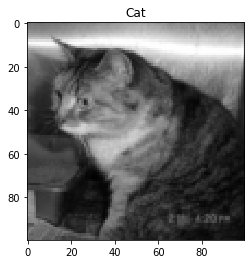

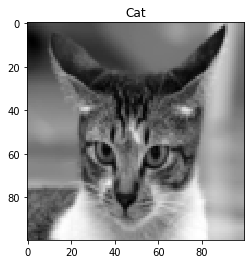

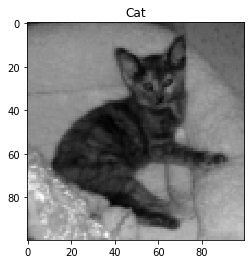

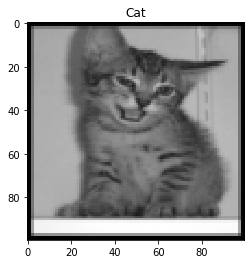

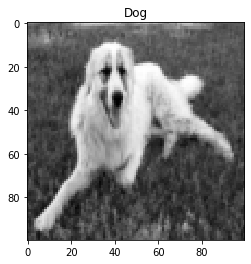

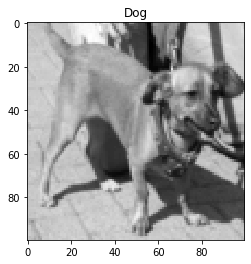

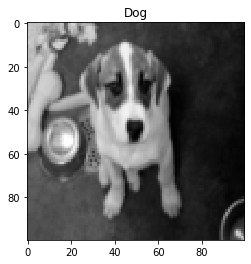

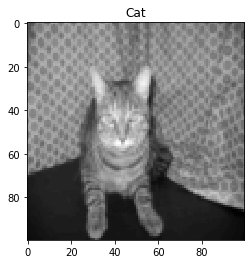

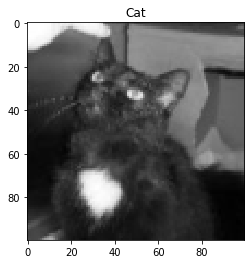

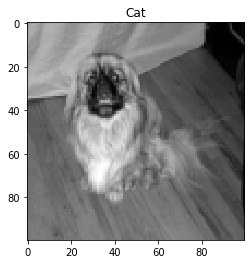

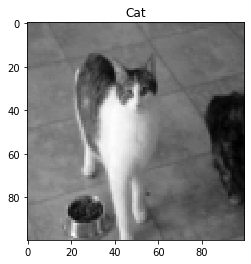

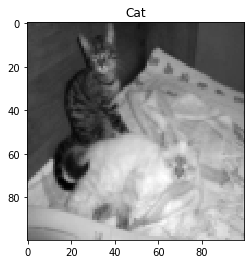

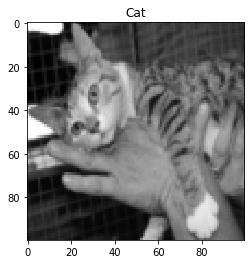

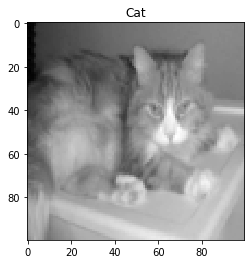

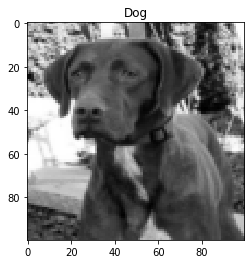

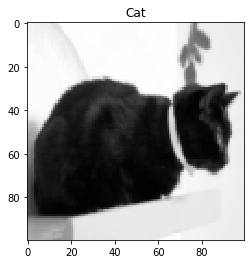

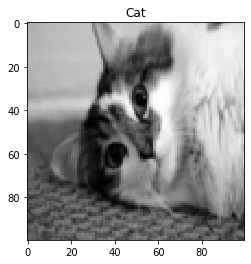

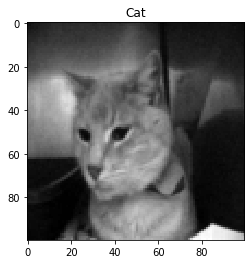

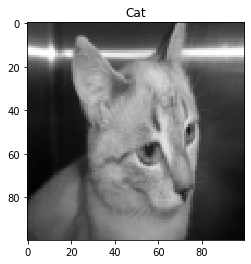

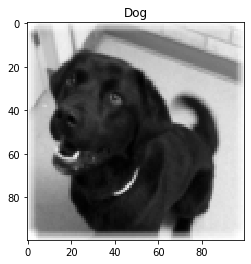

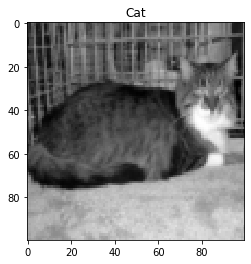

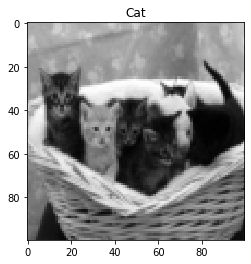

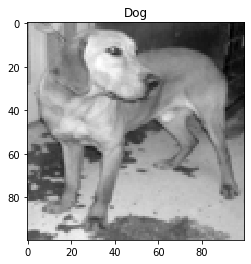

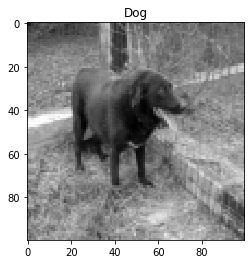

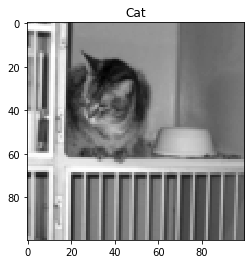

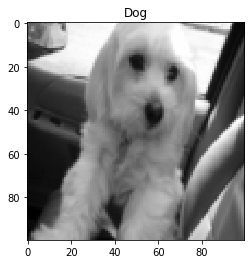

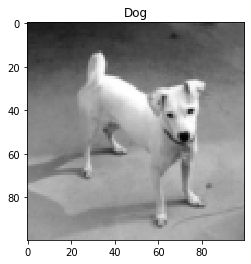

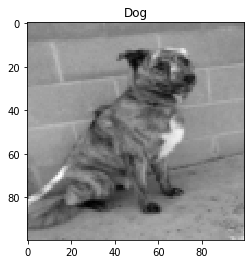

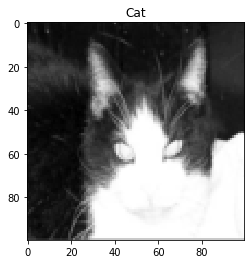

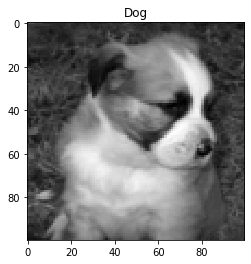

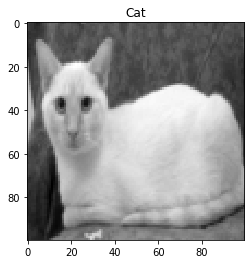

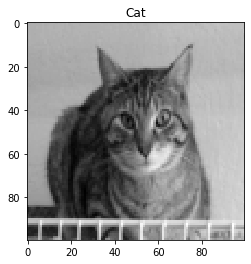

Accuracy on the test set 94.1


In [20]:
print('Some predictions')
test()